In [22]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans

import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


#### 데이터 준비

In [2]:
df = pd.read_csv('/home/user/exercise_j/TwitterXAPI/10000Tweets_Crypto_data.csv')

In [3]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.sort_values(by='created_at', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,created_at,text,ticker,sentiment_score
0,2010-10-30,Absolutely Stunning Vector Inspiration http://...,BTC,0.00
1,2010-11-01,@yogavenger Thanks for the RTs,BTC,0.75
2,2010-11-03,Massive Social Media Icon Collection http://bi...,BTC,0.00
3,2010-11-04,Is the User Mastermind Behind Web Design? http...,BTC,0.00
4,2010-11-05,Everyone give a big happy birthday to @robertb...,BTC,0.00


#### (가장 데이터가 많이 존재하는)최근 6개월의 데이터로 input_data 설정
##### 2023.06.01 ~ 2023.12.31

In [4]:
start_date = '2023-06-01'
end_date = '2023-12-31'
filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])
filtered_df

,created_at,text,ticker,sentiment_score
0,2023-06-01,The Fed and Treasury are using interest income...,BTC,0.8
1,2023-06-01,RT @vdWijden: Are you interested in core devel...,ETH,0.0
2,2023-06-01,RT @TMIYChao: Ethereum is for everyone and the...,ETH,0.0
3,2023-06-01,@gregthegreek Maybe we should just airdrop (bi...,ETH,0.0
4,2023-06-02,@lightclients There might be too much alpha in...,ETH,0.0
...,...,...,...,...
4437,2023-12-31,RT @xrpmemeguy: Do you know why Patrick McHenr...,XRP,0.0
4438,2023-12-31,"XRP ETF / Ripple Win , United States Of Corrup...",XRP,0.0
4439,2023-12-31,"RT @zerohedge: ""We Are Going To See 'Collision...",BTC,0.0
4440,2023-12-31,My Theory: FTX was created for the specific pu...,SOL,-1.0


1. 티커별로 분류
2. 각 티커별로 input_data 생성
 - input_data의 구성은 created_at sentiment_score

In [5]:
# 1. 티커별로 데이터프레임을 분류
tickers = filtered_df['ticker'].unique()
ticker_dfs = {ticker: filtered_df[filtered_df['ticker'] == ticker] for ticker in tickers}

# 2. 각 티커에 대한 input_data를 생성
# input_data는 'created_at'과 'sentiment_score'만 포함
input_data = {ticker: filtered_df[['created_at', 'sentiment_score']] for ticker, filtered_df in ticker_dfs.items()}

input_data['ETH'] 

,created_at,sentiment_score
1,2023-06-01,0.00
2,2023-06-01,0.00
3,2023-06-01,0.00
4,2023-06-02,0.00
11,2023-06-05,0.25
...,...,...
4400,2023-12-30,-0.50
4411,2023-12-30,-0.60
4419,2023-12-30,-0.50
4427,2023-12-31,0.00


In [6]:
grouped_input_data = {}
for ticker, df in ticker_dfs.items():
    grouped_df = df.groupby('created_at')['sentiment_score'].sum().reset_index()
    grouped_input_data[ticker] = grouped_df

grouped_input_data

{'BTC':     created_at  sentiment_score
 0   2023-06-01             0.80
 1   2023-06-04             0.00
 2   2023-06-06             1.50
 3   2023-06-07             0.00
 4   2023-06-09             0.00
 ..         ...              ...
 175 2023-12-27             1.65
 176 2023-12-28            -0.50
 177 2023-12-29             0.10
 178 2023-12-30            -1.00
 179 2023-12-31             0.45
 
 [180 rows x 2 columns],
 'ETH':     created_at  sentiment_score
 0   2023-06-01             0.00
 1   2023-06-02             0.00
 2   2023-06-05             0.50
 3   2023-06-06             0.50
 4   2023-06-08             5.95
 ..         ...              ...
 171 2023-12-27            -1.65
 172 2023-12-28             0.00
 173 2023-12-29            -2.00
 174 2023-12-30            -1.60
 175 2023-12-31            -0.50
 
 [176 rows x 2 columns],
 'UNI':    created_at  sentiment_score
 0  2023-06-02            -1.00
 1  2023-06-03            -0.75
 2  2023-06-04             0.80
 3  2

#### 각 크립토 거래 종가, 거래 규모 데이터 (2023.06.01 ~ 2023.12.31)

In [7]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [8]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    del df['변동 %']
    del df['고가']
    del df['시가']
    del df['저가']
    
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']

    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


In [9]:
filtered_dfs['ETH']

,종가,거래량,created_at
0,"2,281.90",232.62K,2023-12-31
1,"2,291.70",219.92K,2023-12-30
2,"2,299.24",475.37K,2023-12-29
3,"2,344.47",626.91K,2023-12-28
4,"2,378.63",577.27K,2023-12-27
...,...,...,...
209,"1,811.20",588.61K,2023-06-05
210,"1,890.04",183.07K,2023-06-04
211,"1,892.05",157.10K,2023-06-03
212,"1,907.10",329.16K,2023-06-02


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [10]:
print(grouped_input_data.keys())
print(filtered_dfs.keys())

dict_keys(['BTC', 'ETH', 'UNI', 'BNB', 'DOT', 'XRP', 'SOL', 'FTT'])
dict_keys(['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI'])


In [11]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

In [12]:
merged_dfs = {}
for ticker in ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP','UNI']:
    merged_df = pd.merge(filtered_dfs[ticker], grouped_input_data[ticker], on='created_at', how='outer')
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)
    merged_df['거래량'] = merged_df['거래량'].apply(convert_volume)
    merged_dfs[ticker] = merged_df

# 결과 출력
merged_dfs

{'BTC':            종가      거래량 created_at  sentiment_score
 0    42,272.5  35580.0 2023-12-31             0.45
 1    42,136.7  35180.0 2023-12-30            -1.00
 2    42,072.4  60980.0 2023-12-29             0.10
 3    42,581.1  49840.0 2023-12-28            -0.50
 4    43,446.5  50100.0 2023-12-27             1.65
 ..        ...      ...        ...              ...
 209  25,747.4  85420.0 2023-06-05             0.00
 210  27,122.3  23810.0 2023-06-04             0.00
 211  27,072.0  20620.0 2023-06-03             0.00
 212  27,244.7  49370.0 2023-06-02             0.00
 213  26,819.0  51980.0 2023-06-01             0.80
 
 [214 rows x 4 columns],
 'ETH':            종가       거래량 created_at  sentiment_score
 0    2,281.90  232620.0 2023-12-31            -0.50
 1    2,291.70  219920.0 2023-12-30            -1.60
 2    2,299.24  475370.0 2023-12-29            -2.00
 3    2,344.47  626910.0 2023-12-28             0.00
 4    2,378.63  577270.0 2023-12-27            -1.65
 ..        ...   

#### 각 티커별 데이터 변환 및 스케일링

In [23]:
scaler = StandardScaler()

In [24]:
processed_data = {}

for ticker, df in merged_dfs.items():
    # '종가' 열 처리: 쉼표 제거, 실수형 변환
    prices = df['종가'].replace(',', '', regex=True).astype(float).values.reshape(-1, 1)

    # '거래량' 열 처리
    volumes = df['거래량'].values.reshape(-1, 1)

    # 'sentiment_score' 열 처리
    sentiments = df['sentiment_score'].values.reshape(-1, 1)

    # (p_t, v_t, s_t) 형태로 결합
    data = np.hstack((prices, volumes, sentiments))
    # 데이터를 표준화
    data = scaler.fit_transform(data)
    
    processed_data[ticker] = data


processed_data['ETH']

array([[ 1.96459763e+00, -4.91013113e-01, -5.04199400e-01],
       [ 2.01000316e+00, -5.68820374e-01, -1.34596209e+00],
       [ 2.04493763e+00,  9.96208345e-01, -1.65205761e+00],
       [ 2.25449807e+00,  1.92462663e+00, -1.21579997e-01],
       [ 2.41276880e+00,  1.62050440e+00, -1.38422403e+00],
       [ 1.72756220e+00,  7.15183223e-01, -1.21579997e-01],
       [ 1.91585618e+00, -8.94173704e-02, -1.21579997e-01],
       [ 1.87967074e+00,  4.02205535e-02, -8.86818803e-01],
       [ 2.08835088e+00, -2.84670709e-01, -5.04199400e-01],
       [ 2.16072174e+00,  1.88676452e+00,  3.20720881e+00],
       [ 1.76870518e+00,  9.72253511e-01,  3.58982821e+00],
       [ 1.59528383e+00,  7.81656355e-01,  1.84515525e-01],
       [ 1.48061169e+00,  5.40208785e-01, -2.03467701e+00],
       [ 1.67224158e+00,  4.62524055e-01, -5.04199400e-01],
       [ 1.57142276e+00, -4.85744275e-01, -1.26943821e+00],
       [ 1.71982473e+00, -6.49262053e-01, -9.25080743e-01],
       [ 1.67970106e+00,  2.25855199e-01

#### 데이터셋 산포도(scatter plot) 확인

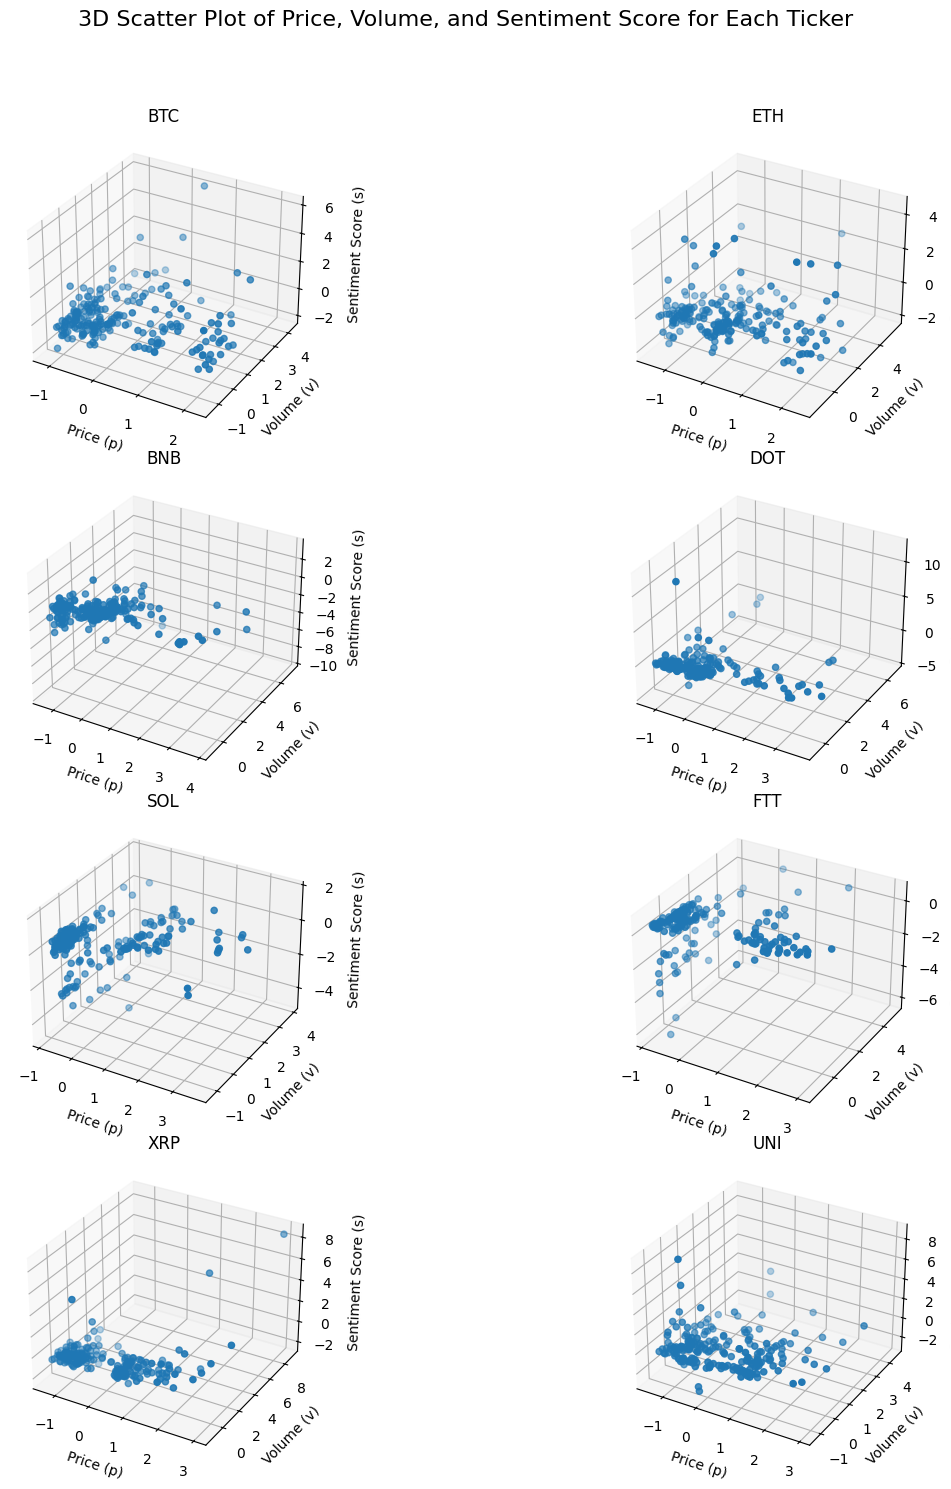

In [25]:

# 3x2 형태의 산포도 그리기
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), subplot_kw={'projection': '3d'})
fig.suptitle('3D Scatter Plot of Price, Volume, and Sentiment Score for Each Ticker', fontsize=16)

# 각 티커별로 그래프 그리기
for idx, (ticker, data) in enumerate(processed_data.items()):
    # 데이터 스케일링
    # scaled_data = scaler.fit_transform(data)
    
    # 서브플롯 위치 계산
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # 각 축에 데이터 플롯
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    
    # 축 레이블 설정
    ax.set_xlabel('Price (p)')
    ax.set_ylabel('Volume (v)')
    ax.set_zlabel('Sentiment Score (s)')

    # 그래프 제목 설정
    ax.set_title(ticker)

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [26]:
from sklearn.cluster import KMeans
import numpy as np

# 클러스터링 결과를 저장할 딕셔너리
clustered_data = {}

# 각 티커별로 클러스터링 수행
for ticker, data in processed_data.items():
    # KMeans 모델 초기화
    # n_clusters는 원하는 클러스터의 개수
    kmeans = KMeans(n_clusters=5, random_state=0)

    # 클러스터링 수행
    clusters = kmeans.fit_predict(data)

    # 클러스터 레이블을 데이터에 추가
    clustered_df = pd.DataFrame(data, columns=['Price', 'Volume', 'Sentiment'])
    clustered_df['Cluster'] = clusters

    # 결과 저장
    clustered_data[ticker] = clustered_df

# 결과 출력
for ticker, c_data in clustered_data.items():
    print(f"Ticker: {ticker}")
    print(c_data.head())  # 상위 5개 행을 출력


Ticker: BTC
      Price    Volume  Sentiment  Cluster
0  1.883238 -0.483024   0.308731        2
1  1.859339 -0.498556  -1.251516        2
2  1.848023  0.503259  -0.067881        2
3  1.937546  0.070692  -0.713500        2
4  2.089843  0.080788   1.599969        0
Ticker: ETH
      Price    Volume  Sentiment  Cluster
0  1.964598 -0.491013  -0.504199        4
1  2.010003 -0.568820  -1.345962        4
2  2.044938  0.996208  -1.652058        4
3  2.254498  1.924627  -0.121580        4
4  2.412769  1.620504  -1.384224        4
Ticker: BNB
      Price    Volume  Sentiment  Cluster
0  3.305883  0.118933   0.347500        2
1  3.506615 -0.102933   0.347500        2
2  3.375703  1.685737  -0.693783        2
3  3.777166  3.476489  -1.908612        2
4  3.829094  3.205794   0.347500        2
Ticker: DOT
      Price    Volume  Sentiment  Cluster
0  2.827783  0.122625  -0.087485        4
1  2.954023 -0.186365  -0.087485        4
2  2.906232  0.852829  -0.087485        4
3  3.029767 -0.132497  -0.08

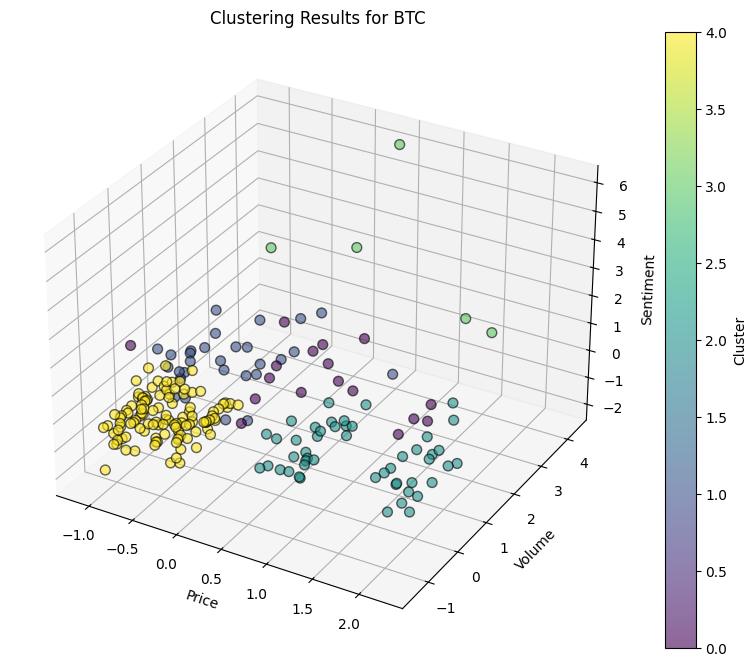

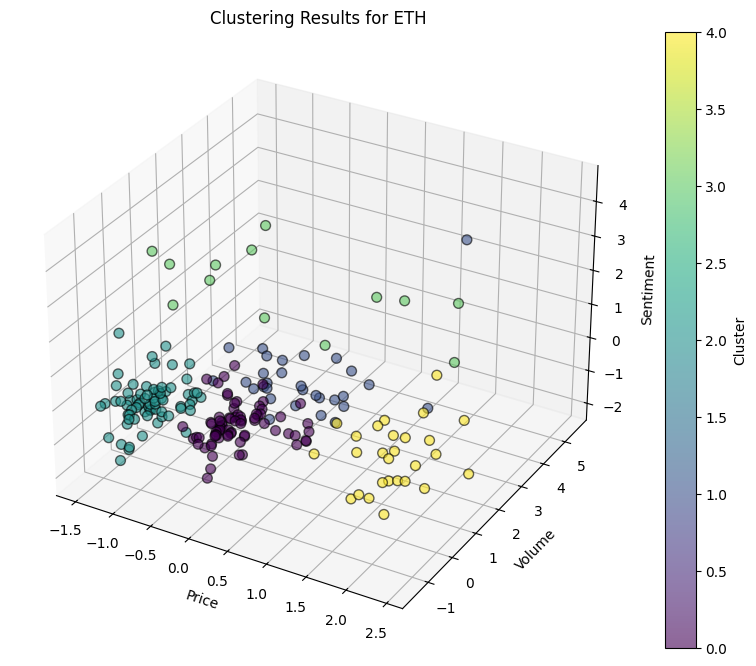

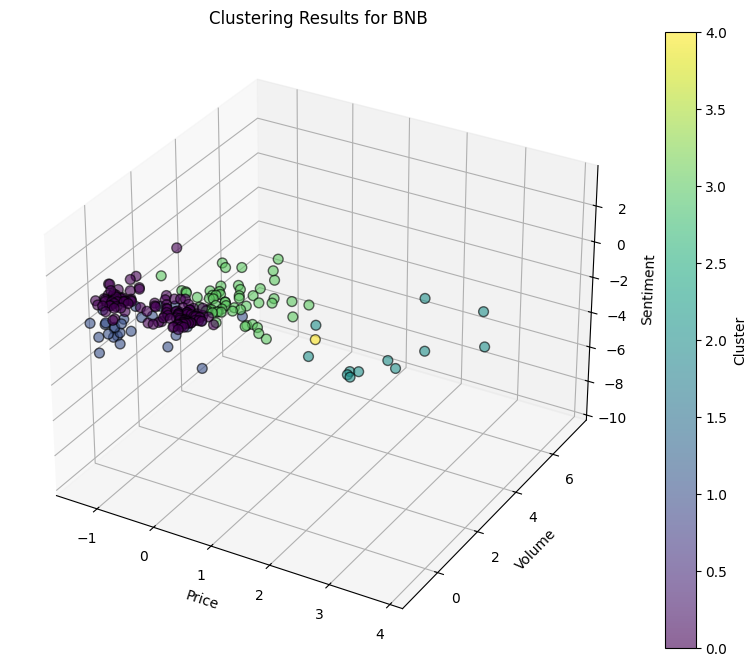

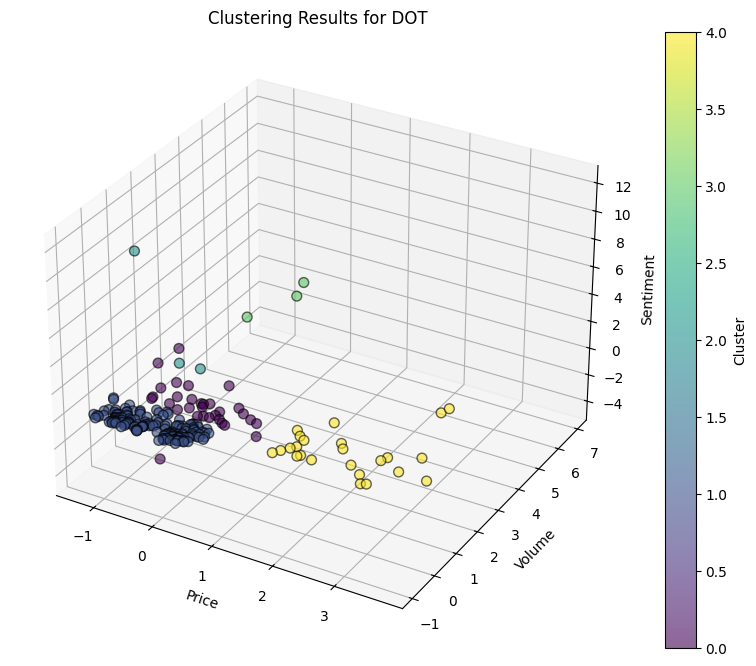

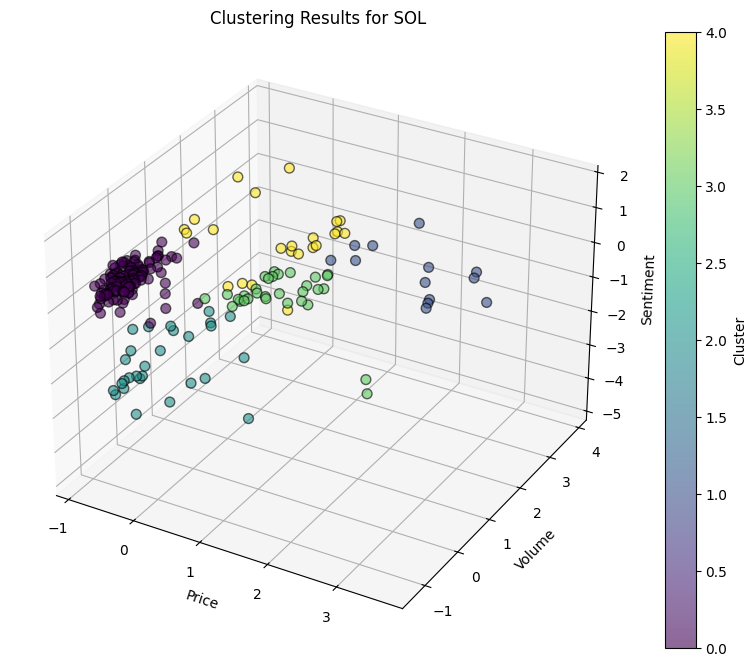

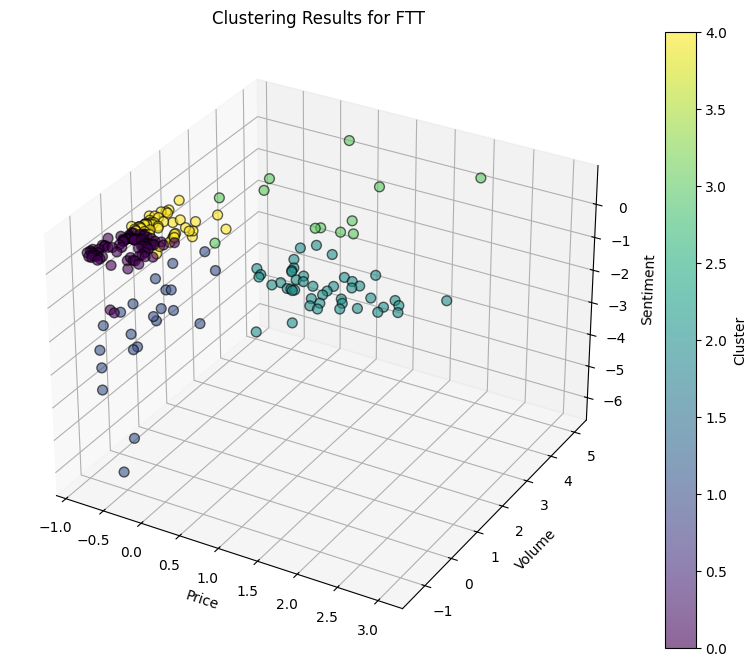

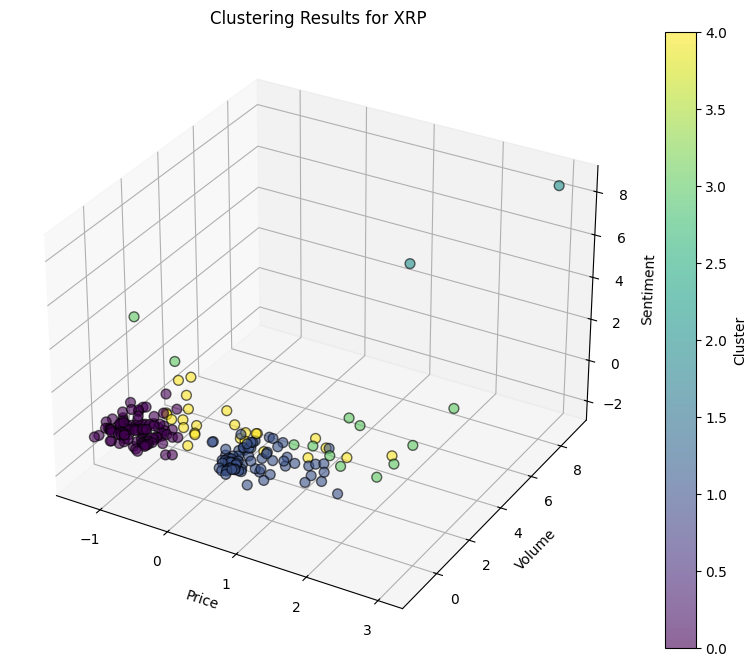

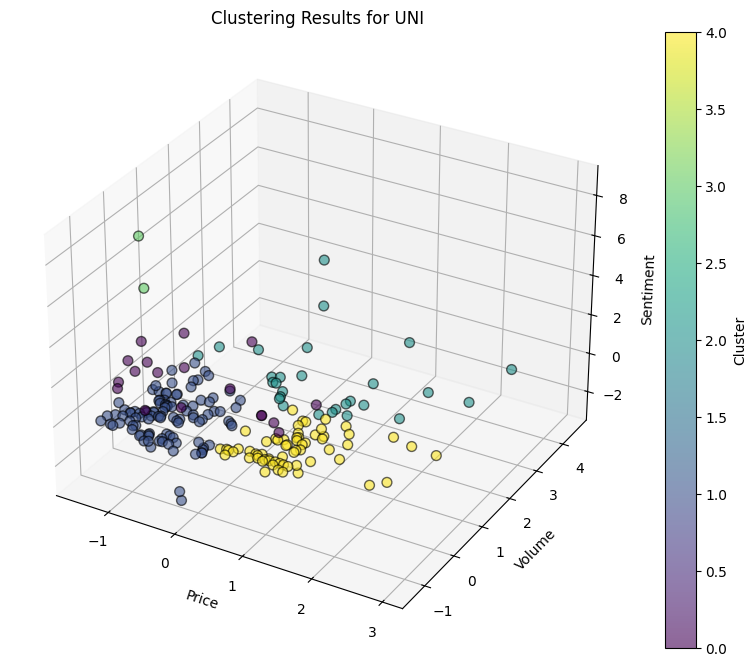

In [27]:
for ticker, c_data in clustered_data.items():
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 산점도 데이터 플롯
    scatter = ax.scatter(c_data['Price'], c_data['Volume'], c_data['Sentiment'],
                         c=c_data['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    
    # 레이블 및 타이틀 설정
    ax.set_title(f'Clustering Results for {ticker}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Volume')
    ax.set_zlabel('Sentiment')
    
    # 클러스터 컬러 바 추가
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster')
    
    plt.show()

#### 통합본 클러스터링

In [37]:
# 모든 티커의 데이터를 하나의 배열로 결합
combined_data = np.vstack(list(processed_data.values()))

# KMeans 모델 초기화 및 클러스터링 수행
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(combined_data)

# 클러스터 레이블을 데이터에 추가하여 데이터프레임 생성
clustered_df = pd.DataFrame(combined_data, columns=['Price', 'Volume', 'Sentiment'])
clustered_df['Cluster'] = clusters

print(clustered_df)

         Price    Volume  Sentiment  Cluster
0     1.883238 -0.483024   0.308731        3
1     1.859339 -0.498556  -1.251516        3
2     1.848023  0.503259  -0.067881        3
3     1.937546  0.070692  -0.713500        3
4     2.089843  0.080788   1.599969        3
...        ...       ...        ...      ...
1707 -0.523672 -0.847501  -0.243934        4
1708 -0.197393 -1.044371   1.702986        4
1709 -0.117207 -1.318656  -2.069170        1
1710 -0.137536 -1.229011  -2.677583        1
1711 -0.234550 -1.242102  -0.243934        4

[1712 rows x 4 columns]


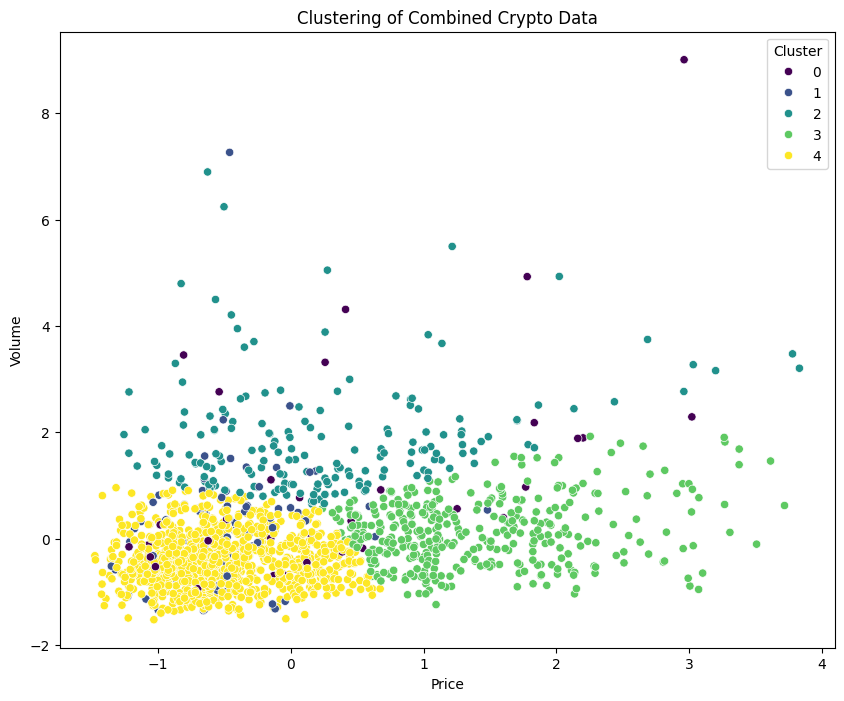

In [29]:
def plot_clusters(data, clusters, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data, x='Price', y='Volume', hue=clusters, palette='viridis')
    plt.title(title)
    plt.show()

# 데이터와 클러스터 레이블을 이용해 시각화
plot_clusters(clustered_df, clustered_df['Cluster'], 'Clustering of Combined Crypto Data')

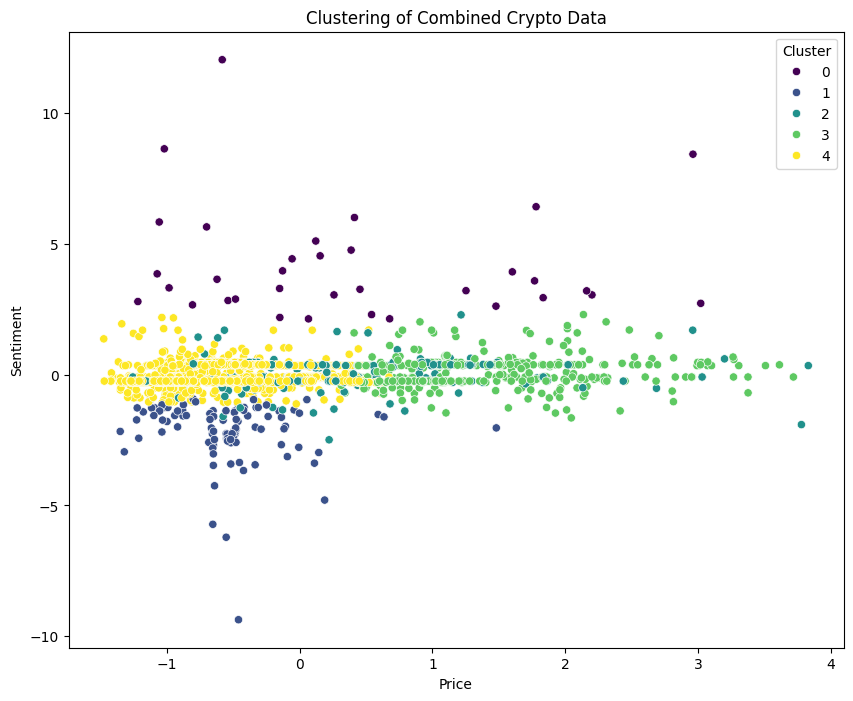

In [30]:
def plot_clusters2(data, clusters, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data, x='Price', y='Sentiment', hue=clusters, palette='viridis')
    plt.title(title)
    plt.show()

# 데이터와 클러스터 레이블을 이용해 시각화
plot_clusters2(clustered_df, clustered_df['Cluster'], 'Clustering of Combined Crypto Data')

In [40]:
# 모든 티커의 데이터를 하나의 데이터프레임으로 결합
combined_df = pd.DataFrame()
for ticker, data in processed_data.items():
    temp_df = pd.DataFrame(data, columns=['Price', 'Volume', 'Sentiment'])
    temp_df['Ticker'] = ticker
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)


# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(combined_df[['Price', 'Volume', 'Sentiment']])

# 클러스터 레이블을 데이터프레임에 추가
combined_df['Cluster'] = clusters

# 클러스터별 데이터 개수 집계
cluster_counts = combined_df.groupby(['Cluster', 'Ticker']).size().unstack(fill_value=0)
print(cluster_counts)

Ticker   BNB  BTC  DOT  ETH  FTT  SOL  UNI  XRP
Cluster                                        
0          1   10    3   10    0    0    5    5
1         19   17    1    8   21   26    3    2
2         23   20   22   27   22   25   29   15
3         36   53   27   41   45   41   64   65
4        135  114  161  128  126  122  113  127


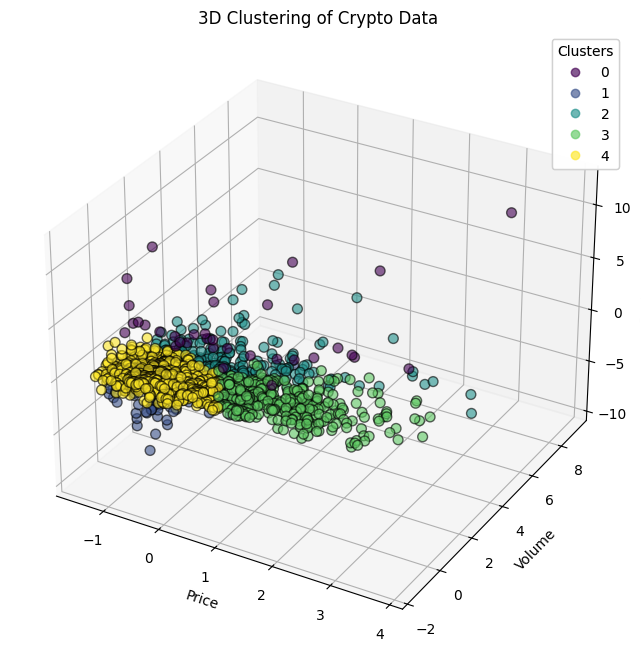

In [42]:
# 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_df['Price'], combined_df['Volume'], combined_df['Sentiment'],
                     c=combined_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

# 클러스터별 범례 추가
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('Price')
ax.set_ylabel('Volume')
ax.set_zlabel('Sentiment')
plt.title('3D Clustering of Crypto Data')
plt.show()


Ticker   BNB  BTC  DOT  ETH  FTT  SOL  UNI  XRP
Cluster                                        
0          1   10    3   10    0    0    5    5
1         19   17    1    8   21   26    3    2
2         23   20   22   27   22   25   29   15
3         36   53   27   41   45   41   64   65
4        135  114  161  128  126  122  113  127


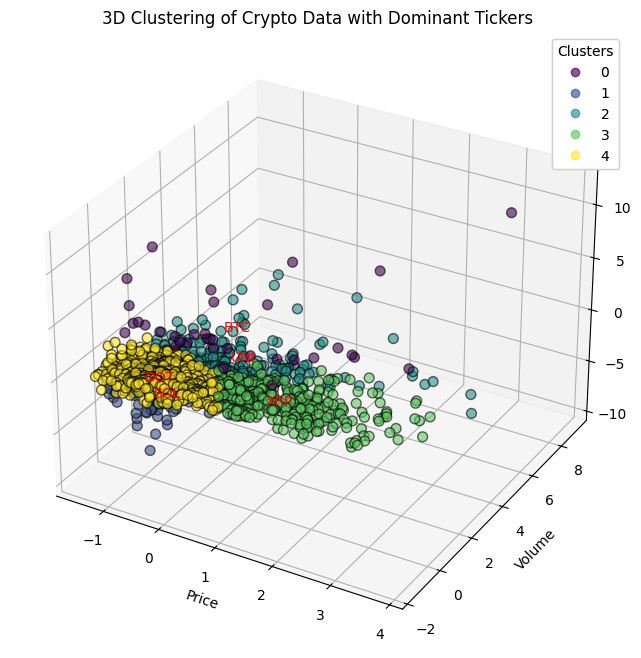

In [43]:
# 클러스터별 대표 티커 결정
def get_dominant_ticker(df):
    return df.groupby('Ticker').size().idxmax()

dominant_tickers = combined_df.groupby('Cluster').apply(get_dominant_ticker)

# 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_df['Price'], combined_df['Volume'], combined_df['Sentiment'],
                     c=combined_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

# 클러스터별 범례 추가
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)
print(cluster_counts)
# 클러스터별 대표 티커 이름 주석 추가
for cluster, ticker in dominant_tickers.items():
    cluster_center = kmeans.cluster_centers_[cluster]
    ax.text(cluster_center[0], cluster_center[1], cluster_center[2], f'{ticker}', color='Red', ha='center', va='center')

ax.set_xlabel('Price')
ax.set_ylabel('Volume')
ax.set_zlabel('Sentiment')
plt.title('3D Clustering of Crypto Data with Dominant Tickers')
plt.show()
